In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [96]:
np.set_printoptions(suppress=True)
TIME_COLUMN_INDEX = 0
OPEN_COLUMN_INDEX = 1
CLOSE_COLUMN_INDEX = 4
VOLUME_COLUMN_INDEX = 5
EPISODE_SIZE = 10000
WINDOW_SIZE = 1200
LOOK_AHEAD = 15
TRAIN_SPLIT = 0.85

In [97]:
def read_data(filename="../data/bitfinex-BTCUSD-1m.csv", date_columns="DateTime"):
    df = pd.read_csv(filename, parse_dates=[date_columns])
    df = df[~np.isnan(df['Close'])].set_index(pd.DatetimeIndex(df[date_columns]))
    df['Volume'] = ((df['Volume'] - df['Volume'].mean())/df['Volume'].std())
    return df

def normalize_episode(df_episode):
    df_episode_norm = df_episode.copy()
    df_episode_norm['Open']  = df_episode_norm['Open'] / df_episode.iloc[0]['Open']
    df_episode_norm['High']  = df_episode_norm['High'] / df_episode.iloc[0]['Open']
    df_episode_norm['Low']   = df_episode_norm['Low']  / df_episode.iloc[0]['Open']
    df_episode_norm['Close'] = df_episode_norm['Close']/df_episode.iloc[0]['Open']
    return df_episode_norm

def get_train_test_sets(df, train_split):
    state_len = df.shape[0]
    train_end_index = int(train_split * state_len)
    train_state = df[0:train_end_index]
    test_state = df[train_end_index:]
    print("Train state: ", train_state.shape, "test state: ", test_state.shape, "total:", state_len)
    return train_state, test_state

def get_state_window_count(state, window_size, look_ahead):
    return state.shape[0] - window_size - look_ahead + 1

def get_features_number(df):
    return df.shape[1] - 1

def get_y_label(episode_data, look_ahead):
    regular_close = episode_data['Close']
    shifted_close = episode_data.shift(-look_ahead)['Close']
    diff = shifted_close - regular_close
    return ((np.sign(diff) + 1)/2).dropna().astype(int), diff

def get_episode_data(state, start_index, episode_size, look_ahead):
    episode_state = state[start_index : start_index + episode_size].copy()
    X_episode = np.array(normalize_episode(episode_state))[:,1:]
    y_label, y_diff = get_y_label(episode_state, look_ahead)
    Y_episode = np.array(y_label)
    return X_episode, Y_episode, y_diff

In [98]:
df = read_data()
train_state, test_state = get_train_test_sets(df, TRAIN_SPLIT)
features_number = get_features_number(df)
train_length = get_state_window_count(train_state, WINDOW_SIZE, LOOK_AHEAD)
test_length = get_state_window_count(test_state, WINDOW_SIZE, LOOK_AHEAD)
train_length, test_length, features_number

Train state:  (686800, 6) test state:  (121200, 6) total: 808000


(685586, 119986, 5)

In [99]:
X_episode, Y_episode, y_diff = get_episode_data(train_state, start_index=675000, episode_size=EPISODE_SIZE, look_ahead=LOOK_AHEAD)
print(X_episode[0:2], Y_episode[0:2], X_episode.shape, Y_episode.shape)

[[1.0 1.0026845255787675 0.9999928476810821 1.0019253343768562
  -0.14518293921277012]
 [1.0019253343768562 1.0032366646347028 0.9993716912431547
  0.9995097260071386 0.8170516479262113]] [0 0] (10000, 5) (9985,)


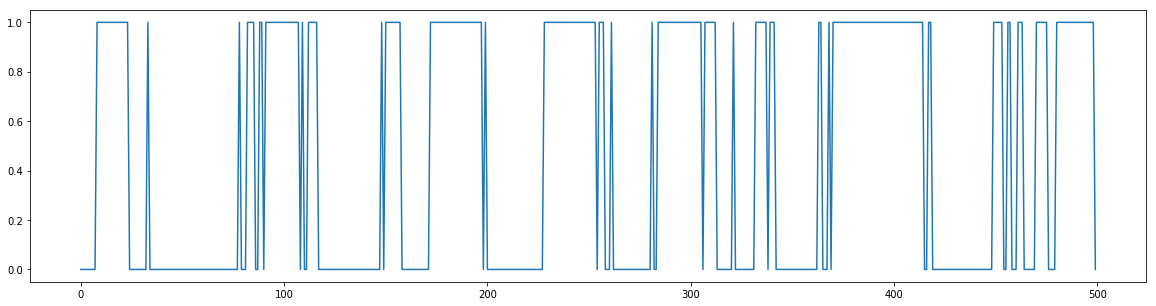

In [100]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(Y_episode[500:1000])
plt.show()

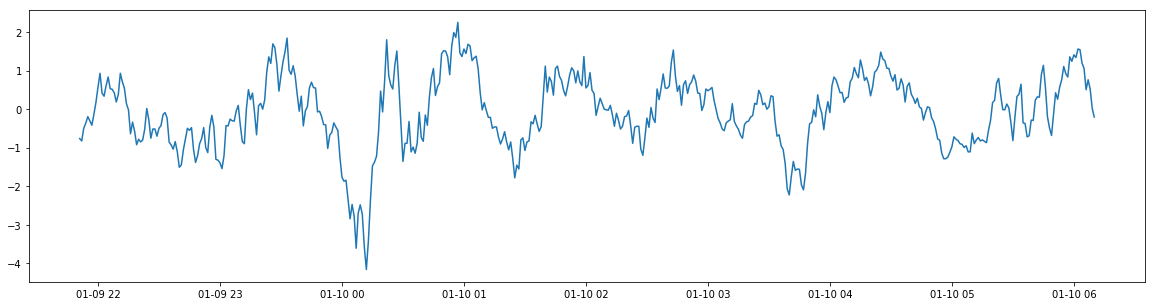

In [101]:
plt.rcParams["figure.figsize"] = (20,5)
y_diff_norm = y_diff/y_diff.std()
plt.plot(y_diff_norm[500:1000])
plt.show()

In [74]:
y_diff.std()

112.79858463765831

In [ ]:
def _normalize_column(df_column, normalize, pct_change):
    column = df_column.copy()
    #if pct_change:
    #    column = column.pct_change()
    column = column.replace(np.inf, np.nan).fillna(0)
    #eps = np.finfo(np.float32).eps
    #column_n = (column - np.array(column.mean())) / np.array(column.std() + eps)
    return column# if not normalize else column_n

def _normalize_state(normalize=True, pct_change=True):
    return np.array([
        df.index.to_pydatetime(),
        _normalize_column(df['Open'], normalize, pct_change).values,
        _normalize_column(df['High'], normalize, pct_change).values,
        _normalize_column(df['Low'], normalize, pct_change).values,
        _normalize_column(df['Close'], normalize, pct_change).values,
        _normalize_column(df['Volume'].fillna(0), normalize, pct_change).values,
    ]).T

In [ ]:
state_norm = _normalize_state(True, True)
state_raw = _normalize_state(False, False)
state = state_raw

In [ ]:
state_len = state.shape[0]
features_number = state.shape[1]
train_end_index = int(train_split * state_len)

In [ ]:
train_state = state[0:train_end_index]
test_state = state[train_end_index:]
print("Train state: ", train_state.shape, "test state: ", test_state.shape)
train_length = train_end_index - window_size - look_ahead + 1
test_length = state_len - window_size - train_end_index - look_ahead + 1

In [ ]:
def _norm_set(X_columns_set):
    mean = X_columns_set.mean()
    std = X_columns_set.std()
    return (X_columns_set - mean) / std, mean, std

def normalize_set(X_window_set):
    new_set = np.zeros_like(X_window_set)
    new_set[TIME_COLUMN_INDEX] = X_window_set[TIME_COLUMN_INDEX, :]
    new_set[OPEN_COLUMN_INDEX:CLOSE_COLUMN_INDEX+1], price_mean, price_std = _norm_set(X_window_set[OPEN_COLUMN_INDEX:CLOSE_COLUMN_INDEX+1, :])
    new_set[VOLUME_COLUMN_INDEX], _, _ = _norm_set(X_window_set[VOLUME_COLUMN_INDEX, :])
    return new_set, price_mean, price_std

In [ ]:
def get_y_label(close_ahead_diff, window_std):
    return int((np.sign(close_ahead_diff) * int(np.abs(close_ahead_diff) - window_std/2 > 0))[0])

In [ ]:
def get_window_diff(state, close_index, price_mean, price_std):
    last_window_close = state[close_index - 1, CLOSE_COLUMN_INDEX] - price_mean
    look_ahead_window_close = state[close_index - 1 + look_ahead, CLOSE_COLUMN_INDEX] - price_mean
    window_close_diff = look_ahead_window_close - last_window_close
    window_close_diff_norm = window_close_diff / price_std
    return window_close_diff_norm

In [ ]:
def get_data(state, length):
    X_set = np.zeros((length, features_number, window_size), dtype=state.dtype)
    y_set = np.zeros((length, 1))
    std_set = np.zeros((length, 1))
    cl_diff_set = np.zeros((length, 1))
    price_meta_set = np.zeros((length, 2))

    for i in range(length):
        X_set[i, :, :], price_mean, price_std = normalize_set(state[i:i + window_size,:].T)
        cl_diff_set[i] = get_window_diff(state, i + window_size, price_mean, price_std)
        std_set[i] = 1  # here we normalise prices above, so std = 1
        y_set[i] = get_y_label(cl_diff_set[i], std_set[i])  
        price_meta_set[i] = [price_mean, price_std]
    return X_set, y_set, std_set, cl_diff_set, price_meta_set

In [ ]:
X_train, y_train, std_train, cl_diff_train, price_meta_train = get_data(train_state, train_length)
print("Train dataset : ", X_train.shape, y_train.shape, std_train.shape, cl_diff_train.shape, price_meta_train.shape)

In [ ]:
print("Buy:  ", cl_diff_train[10101], 1);assert(get_y_label(cl_diff_train[10101], std_train[10101]) == 1)
print("Hold: ", cl_diff_train[11300], 0);assert(get_y_label(cl_diff_train[11300], std_train[11300]) == 0)
print("Sell: ", cl_diff_train[11425], -1);assert(get_y_label(cl_diff_train[11425], std_train[11425]) == -1)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.abs(cl_diff_train))
plt.plot(std_train)
plt.show()

In [ ]:
len(y_train[y_train > 0]), len(y_train[y_train == 0]), len(y_train[y_train < 0])

In [ ]:
X_test, y_test, std_test, cl_diff_test, price_meta_test = get_data(test_state, test_length)
print("Test dataset :  ", X_test.shape, "", y_test.shape, "", std_test.shape, "", cl_diff_test.shape, "", price_meta_test.shape)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.abs(cl_diff_test))
plt.plot(std_test)
plt.show()

In [ ]:
len(y_test[y_test > 0]), len(y_test[y_test == 0]), len(y_test[y_test < 0])

In [ ]:
from utils.renderer import render

def render_for_index(X_set, y_set, meta_set, index, denormalize=False):
    values = X_set[index + look_ahead].copy()
    if denormalize:
        values[OPEN_COLUMN_INDEX:CLOSE_COLUMN_INDEX+1] *= price_meta_train[index + look_ahead][1]
        values[OPEN_COLUMN_INDEX:CLOSE_COLUMN_INDEX+1] += price_meta_train[index + look_ahead][0]
    trades = np.zeros((2, values.shape[1]))
    trade_values = np.concatenate((values, trades), axis=0)
    print("Index: ", index, " Rendering for index+5:", index+5, "Y value:",  y_set[index])
    render(trade_values.T, title="X", scale=1)

In [ ]:
render_for_index(X_train, y_train, price_meta_train, index=11402, denormalize=True)

In [ ]:
print("Train dataset : ", X_train.shape, y_train.shape, price_meta_train.shape)
print("Test dataset : ", X_test.shape, y_test.shape, price_meta_test.shape)
print("Train dataset metrics : ", X_train[:, 1:].mean(), X_train[:, 1:].std())
print("Test dataset : ", X_test[:, 1:].mean(), X_test[:, 1:].std())
print("Nb classes : ", len(np.unique(y_train)))

In [ ]:
FOLDER = "data/trading/"
np.save(FOLDER + 'X_train.npy', X_train)
np.save(FOLDER + 'y_train.npy', y_train)
np.save(FOLDER + 'price_meta_train.npy', price_meta_train)
np.save(FOLDER + 'X_test.npy', X_test)
np.save(FOLDER + 'y_test.npy', y_test)
np.save(FOLDER + 'price_meta_test.npy', price_meta_test)